# Week 5 - Classifying Meanings & Documents

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


drive/  sample_data/


In [ ]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook




!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud 

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math


import pandas as pd

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-a6hsc324
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-a6hsc324
     |████████████████████████████████| 5.6 MB 4.4 MB/s 
     |████████████████████████████████| 117 kB 40.5 MB/s 
     |████████████████████████████████| 180 kB 46.2 MB/s 
     |████████████████████████████████| 76 kB 4.3 MB/s 
     |████████████████████████████████| 132 kB 17.5 MB/s 
     |████████████████████████████████| 32.8 MB 154 kB/s 
     |████████████████████████████████| 8.5 MB 10.2 MB/s 
     |████████████████████████████████| 79 kB 3.6 MB/s 
     |████████████████████████████████| 138 kB 44.0 MB/s 
     |████████████████████████████████| 63 kB 843 kB/s 
     |████████████████████████████████| 5.1 MB 32.1 MB/s 
     |████████████████████████████████| 127 kB 39.5 MB/s 
  Created wheel for lucem-illud: filename=lucem_illud-8.0.1-py3-n

# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain. Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [ ]:
x["Answer.reason.label"]

In [ ]:
x.groupby('WorkerId')["Answer.reason.label"].apply(list)

WorkerId
A1NF6PELRKACS9    [His giving will have a big impact, His giving...
A1WY3YGT618GC0    [Other, He cares about a specific issue, He th...
A1YSYI926BBOHW    [He thinks giving is good, His giving will hav...
A2ELXYKRPPGRPB    [His giving will have a big impact, He thinks ...
A2HM35CWB7IIFM    [He wants to give back to the people, countrie...
A3AJR1PM02424Y    [He cares about a specific issue, His giving w...
AFU00NU09CFXE     [He cares about a specific issue, His giving w...
Name: Answer.reason.label, dtype: object

array([[ 0., nan,  0.,  3., nan, nan, nan, nan, nan, nan],
       [ 1.,  3.,  2.,  2.,  0.,  1.,  3.,  1.,  2.,  0.],
       [ 2.,  0.,  0.,  4.,  1.,  2.,  0.,  5.,  3.,  0.],
       [nan,  0., nan, nan,  2.,  4.,  3., nan,  3.,  2.],
       [nan, nan, nan, nan, nan, nan, nan,  5., nan, nan],
       [ 3.,  0.,  3.,  3.,  5.,  3.,  3.,  5.,  3.,  0.],
       [ 3.,  0.,  3.,  2.,  2.,  0.,  0.,  2.,  0.,  0.]])

ValueError: ignored

In [ ]:
i = 1
temp[i:i+1]

Input.letter_url,https://givingpledge.org/pledger?pledgerId=159,https://givingpledge.org/pledger?pledgerId=160,https://givingpledge.org/pledger?pledgerId=164,https://givingpledge.org/pledger?pledgerId=166,https://givingpledge.org/pledger?pledgerId=394,https://givingpledge.org/pledger?pledgerId=398,https://givingpledge.org/pledger?pledgerId=409,https://givingpledge.org/pledger?pledgerId=415,https://givingpledge.org/pledger?pledgerId=430,https://givingpledge.org/pledger?pledgerId=437
WorkerId,,,,,,,,,,
A1WY3YGT618GC0,Other,He cares about a specific issue,He thinks giving is good,He thinks giving is good,His giving will have a big impact,Other,He cares about a specific issue,Other,He thinks giving is good,His giving will have a big impact


In [ ]:
gp

array([[ 0., -1.,  0.,  3., -1., -1., -1., -1., -1., -1.],
       [ 1.,  3.,  2.,  2.,  0.,  1.,  3.,  1.,  2.,  0.],
       [ 2.,  0.,  0.,  4.,  1.,  2.,  0.,  5.,  3.,  0.],
       [-1.,  0., -1., -1.,  2.,  4.,  3., -1.,  3.,  2.],
       [-1., -1., -1., -1., -1., -1., -1.,  5., -1., -1.],
       [ 3.,  0.,  3.,  3.,  5.,  3.,  3.,  5.,  3.,  0.],
       [ 3.,  0.,  3.,  2.,  2.,  0.,  0.,  2.,  0.,  0.]])

In [ ]:
#MY CODE
import pandas as pd
path = '/content/drive/MyDrive/Batch_4668757_batch_results.csv'
x = pd.read_csv(path)
x["Answer.reason.label"] = pd.factorize(x["Answer.reason.label"])[0]
temp = x.pivot(index='WorkerId', columns="Input.letter_url", values="Answer.reason.label")
temp = temp.fillna(-1.)
gp = temp.values

anno = AnnotationsContainer.from_array(gp, missing_values=[-1])

In [13]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#content/drive/MyDrive//data/pyAnno/testdata_numerical.txt"

from google.colab import drive
drive.mount('/content/drive')


path = '/content/drive/MyDrive/2021/uchicago-pyanno-master/data/testdata_numerical.txt'

x = np.loadtxt(path)
anno = AnnotationsContainer.from_array(x, missing_values=[-2])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
x

array([[ 2.,  3.,  4., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 3.,  3.,  2., ..., -1., -1., -1.],
       ...,
       [ 3.,  3., -1., ..., -1., -1.,  2.],
       [ 3.,  3., -1., ..., -1., -1.,  4.],
       [ 2.,  2., -1., ..., -1., -1.,  1.]])

In [ ]:
path = '/content/drive/MyDrive/2021/uchicago-pyanno-master/data/testdata_numerical.txt'

x = np.loadtxt(path)
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [ ]:
x

array([[ 2.,  3.,  4., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 3.,  3.,  2., ..., -1., -1., -1.],
       ...,
       [ 3.,  3., -1., ..., -1., -1.,  2.],
       [ 3.,  3., -1., ..., -1., -1.,  4.],
       [ 2.,  2., -1., ..., -1., -1.,  1.]])

In [ ]:
anno.labels

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

Interrogate the AnnotationsContainer object.

In [ ]:
anno.annotations[:,1]

array([-1,  3,  0,  0, -1,  0,  0])

In [ ]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [ ]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

<module 'pyanno' from '/usr/local/lib/python3.7/dist-packages/pyanno/__init__.py'>

In [ ]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.32, 0.08, 0.2 , 0.28, 0.04, 0.08])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


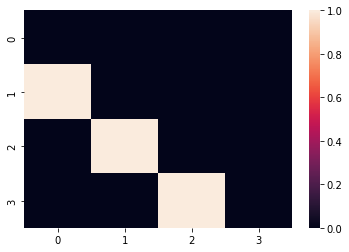

In [ ]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,4],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [ ]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

-0.5625

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [ ]:
fleiss_kappa(anno.annotations[::])

PyannoValueError: ignored

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [ ]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [ ]:
cohens_kappa(anno.annotations[:,2], anno.annotations[:,4])

-0.19047619047619052

In [ ]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[ 1.00000000e+00 -3.15789474e-01  4.44444444e-01 -5.26315789e-02
  -1.90476190e-01  6.87500000e-01 -1.02941176e-01  1.84782609e-01
  -1.02941176e-01 -2.50000000e-01]
 [-3.15789474e-01  1.00000000e+00 -2.50000000e-01 -8.69565217e-02
  -1.90476190e-01 -3.46944695e-17  2.85714286e-01  0.00000000e+00
  -1.11111111e-01 -1.11111111e-01]
 [ 4.44444444e-01 -2.50000000e-01  1.00000000e+00  2.10526316e-01
  -1.90476190e-01  6.25000000e-02  1.66666667e-01 -4.16666667e-02
   2.18750000e-01 -1.71875000e-01]
 [-5.26315789e-02 -8.69565217e-02  2.10526316e-01  1.00000000e+00
   1.07142857e-01  6.25000000e-02  1.31578947e-02  1.84782609e-01
   2.64705882e-01 -8.69565217e-02]
 [-1.90476190e-01 -1.90476190e-01 -1.90476190e-01  1.07142857e-01
   1.00000000e+00 -1.90476190e-01 -8.69565217e-02  3.42105263e-01
  -1.36363636e-01  2.10526316e-01]
 [ 6.87500000e-01 -3.46944695e-17  6.25000000e-02  6.25000000e-02
  -1.90476190e-01  1.00000000e+00  2.50000000e-01  1.84782609e-01
   2.50000000e-01 -3.46944695e-17

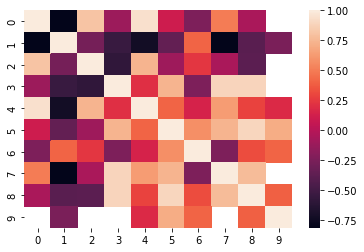

In [ ]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [ ]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.03958690011419741

In [ ]:
anno.annotations

array([[ 0, -1,  0,  3, -1, -1, -1, -1, -1, -1],
       [ 1,  3,  2,  2,  0,  1,  3,  1,  2,  0],
       [ 2,  0,  0,  4,  1,  2,  0,  5,  3,  0],
       [-1,  0, -1, -1,  2,  4,  3, -1,  3,  2],
       [-1, -1, -1, -1, -1, -1, -1,  5, -1, -1],
       [ 3,  0,  3,  3,  5,  3,  3,  5,  3,  0],
       [ 3,  0,  3,  2,  2,  0,  0,  2,  0,  0]])

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [ ]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

-0.4880952380952379

Or averaged over the total:

In [ ]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.07624802291005757

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


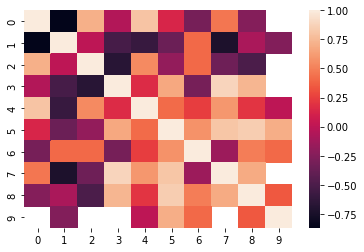

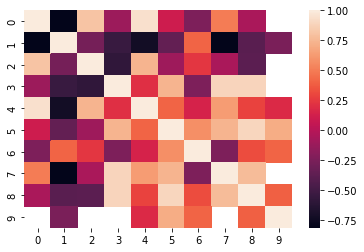

In [ ]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [ ]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/39937/files/6674661?wrap=1), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [ ]:
import pandas as pd
path = '/content/drive/MyDrive/Batch_4668757_batch_results.csv'
x = pd.read_csv(path)
x["Answer.reason.label.fact"] = pd.factorize(x["Answer.reason.label"])[0]
temp0 = x.pivot(index='WorkerId', columns="Input.letter_url", values="Answer.reason.label.fact")
temp = temp0.fillna(-1.)
gp = temp.values

anno = AnnotationsContainer.from_array(gp, missing_values=[1, -1])

In [ ]:
x.pivot(index='WorkerId', columns="Input.letter_url", values="Answer.reason.label")

Input.letter_url,https://givingpledge.org/pledger?pledgerId=159,https://givingpledge.org/pledger?pledgerId=160,https://givingpledge.org/pledger?pledgerId=164,https://givingpledge.org/pledger?pledgerId=166,https://givingpledge.org/pledger?pledgerId=394,https://givingpledge.org/pledger?pledgerId=398,https://givingpledge.org/pledger?pledgerId=409,https://givingpledge.org/pledger?pledgerId=415,https://givingpledge.org/pledger?pledgerId=430,https://givingpledge.org/pledger?pledgerId=437
WorkerId,,,,,,,,,,
A1NF6PELRKACS9,His giving will have a big impact,NaN,His giving will have a big impact,He cares about a specific issue,NaN,NaN,NaN,NaN,NaN,NaN
A1WY3YGT618GC0,Other,He cares about a specific issue,He thinks giving is good,He thinks giving is good,His giving will have a big impact,Other,He cares about a specific issue,Other,He thinks giving is good,His giving will have a big impact
A1YSYI926BBOHW,He thinks giving is good,His giving will have a big impact,His giving will have a big impact,He thinks giving will make his life better,Other,He thinks giving is good,His giving will have a big impact,"He wants to give back to the people, countries...",He cares about a specific issue,His giving will have a big impact
A2ELXYKRPPGRPB,NaN,His giving will have a big impact,NaN,NaN,He thinks giving is good,He thinks giving will make his life better,He cares about a specific issue,NaN,He cares about a specific issue,He thinks giving is good
A2HM35CWB7IIFM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"He wants to give back to the people, countries...",NaN,NaN
A3AJR1PM02424Y,He cares about a specific issue,His giving will have a big impact,He cares about a specific issue,He cares about a specific issue,"He wants to give back to the people, countries...",He cares about a specific issue,He cares about a specific issue,"He wants to give back to the people, countries...",He cares about a specific issue,His giving will have a big impact
AFU00NU09CFXE,He cares about a specific issue,His giving will have a big impact,He cares about a specific issue,He thinks giving is good,He thinks giving is good,His giving will have a big impact,His giving will have a big impact,He thinks giving is good,His giving will have a big impact,His giving will have a big impact


In [ ]:
gp

array([[ 0., -1.,  0.,  3., -1., -1., -1., -1., -1., -1.],
       [ 1.,  3.,  2.,  2.,  0.,  1.,  3.,  1.,  2.,  0.],
       [ 2.,  0.,  0.,  4.,  1.,  2.,  0.,  5.,  3.,  0.],
       [-1.,  0., -1., -1.,  2.,  4.,  3., -1.,  3.,  2.],
       [-1., -1., -1., -1., -1., -1., -1.,  5., -1., -1.],
       [ 3.,  0.,  3.,  3.,  5.,  3.,  3.,  5.,  3.,  0.],
       [ 3.,  0.,  3.,  2.,  2.,  0.,  0.,  2.,  0.,  0.]])

In [ ]:
anno.annotations

array([[ 0, -1,  0,  2, -1, -1, -1, -1, -1, -1],
       [-1,  2,  1,  1,  0, -1,  2, -1,  1,  0],
       [ 1,  0,  0,  3, -1,  1,  0,  4,  2,  0],
       [-1,  0, -1, -1,  1,  3,  2, -1,  2,  1],
       [-1, -1, -1, -1, -1, -1, -1,  4, -1, -1],
       [ 2,  0,  2,  2,  4,  2,  2,  4,  2,  0],
       [ 2,  0,  2,  1,  1,  0,  0,  1,  0,  0]])

In [ ]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations) # score low, annotations perhaps not reliable

0.042676391310021114

# Simple Simulated Examples for Classification

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [ ]:
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:    
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [ ]:
noise = .2

#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

In [ ]:

lucem_illud.xorSplit(0.2)

,vect,category
0,"[0.5670979542017132, -0.5708239359135644]",0
1,"[-1.0462738885837068, -0.814614815184667]",1
2,"[0.3994905656923786, -0.3150434389661206]",0
3,"[-0.41512438732744783, -0.15198115376203128]",1
4,"[-0.2900209198897095, -0.017119526522313355]",0
...,...,...
995,"[-0.9239982769902685, -0.6041233100053518]",1
996,"[0.4683727550916737, -1.2117284437321216]",0
997,"[0.4066043104277517, 0.37587954820877423]",1
998,"[0.568923554079808, -0.6750092545112325]",0


We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [ ]:
dfTrain

,vect,category
22,"[-0.15908895050323077, -0.07268802175798512]",0
613,"[-0.6724767619572779, -0.0559657870912035]",1
300,"[-0.03946860506950993, -0.1684667779895718]",0
938,"[0.14363059471325298, -0.1322803958623122]",0
460,"[-0.19164827613512408, -0.06640490486995311]",0
...,...,...
937,"[0.20224292220038756, -0.7781355303313737]",1
654,"[-0.039024575597612826, -0.04834596995632521]",0
739,"[-0.7204778710070766, 0.2580365757394704]",1
581,"[0.045439088526845126, -0.4387366444885448]",1


So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [ ]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


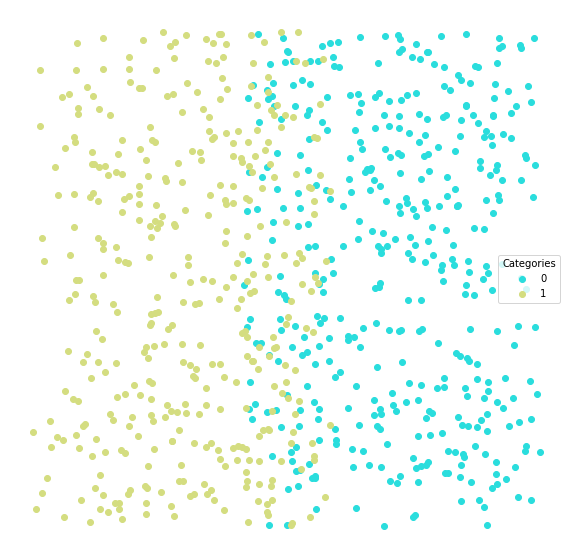

In [ ]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [ ]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()



Now we fit the model by giving it our training data

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB()

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.022,0.961296,0.960396,0.909754,0.932692
1,0.022,0.966015,0.936842,0.897010,0.946809
2,0.000,1.000000,1.000000,1.000000,1.000000
3,0.002,0.998753,0.990000,0.990000,1.000000
4,0.002,0.998728,0.990741,0.990741,1.000000


This lets us look at which classes do better:

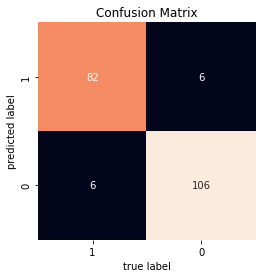

In [ ]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

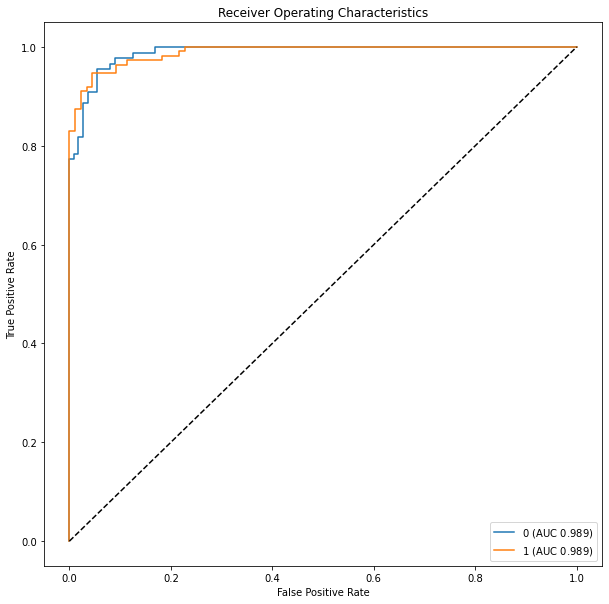

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


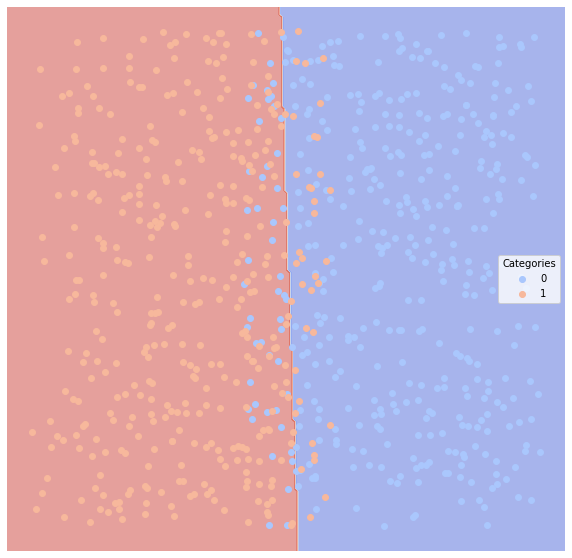

In [ ]:
lucem_illud.plotregions(clf, dfTrain)

In [ ]:
algorithms = [sklearn.naive_bayes.GaussianNB(), sklearn.svm.SVC(kernel = 'linear', probability = True), sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True), sklearn.neighbors.KNeighborsClassifier(5, weights='distance'), sklearn.linear_model.LogisticRegression(), sklearn.tree.DecisionTreeClassifier(), sklearn.tree.DecisionTreeClassifier(), sklearn.ensemble.RandomForestClassifier(), sklearn.neural_network.MLPClassifier(), sklearn.ensemble.GradientBoostingClassifier()]

In [ ]:
datasets = [
            sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.05),
            sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2),
            sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.5),
            sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.05),
            sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2),
            sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.5),
            sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.05),
            sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2),
            sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.5),
            sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.05),
            sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2),
            sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.5)

]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Count:
1



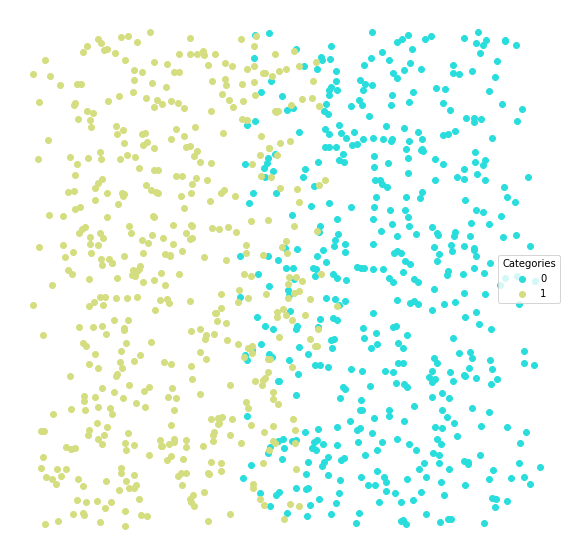

GaussianNB()
          Error_Rate     AUC  Precision  Average_Precision  Recall
Category                                                          
0               0.06  0.9375   0.896552           0.896552   1.000
1               0.06  0.9375   1.000000           0.935000   0.875
SVC(kernel='linear', probability=True)
          Error_Rate     AUC  Precision  Average_Precision  Recall
Category                                                          
0               0.06  0.9375   0.896552           0.896552   1.000
1               0.06  0.9375   1.000000           0.935000   0.875
SVC(kernel='poly', probability=True)
          Error_Rate     AUC  Precision  Average_Precision  Recall
Category                                                          
0               0.06  0.9375   0.896552           0.896552   1.000
1               0.06  0.9375   1.000000           0.935000   0.875
KNeighborsClassifier(weights='distance')
          Error_Rate       AUC  Precision  Average_Precision    Re

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


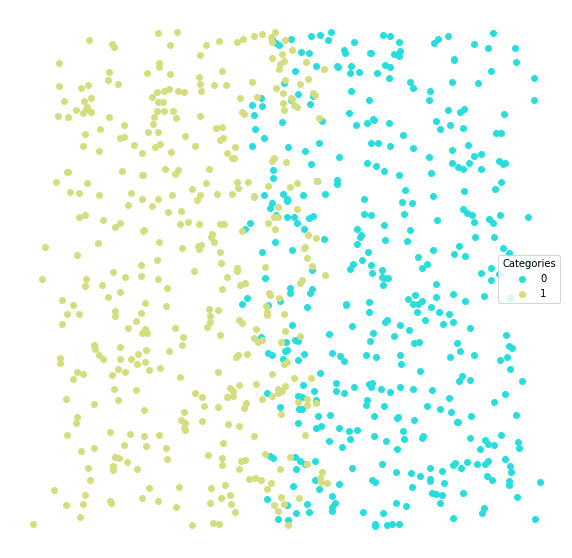

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.115  0.883681   0.890110           0.832010  0.861702
1              0.115  0.883681   0.880734           0.847646  0.905660
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.115  0.883681   0.890110           0.832010  0.861702
1              0.115  0.883681   0.880734           0.847646  0.905660
SVC(kernel='poly', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.125  0.871236   0.915663           0.830323  0.808511
1              0.125  0.871236   0.846154           0.825276  0.933962
KNeighborsClassifier(weights='distance')
          Error_Ra

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.115  0.883681   0.890110           0.832010  0.861702
1              0.115  0.883681   0.880734           0.847646  0.905660
GradientBoostingClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.13  0.871337       0.84           0.800638  0.893617
1               0.13  0.871337       0.90           0.844151  0.849057

Count:
3



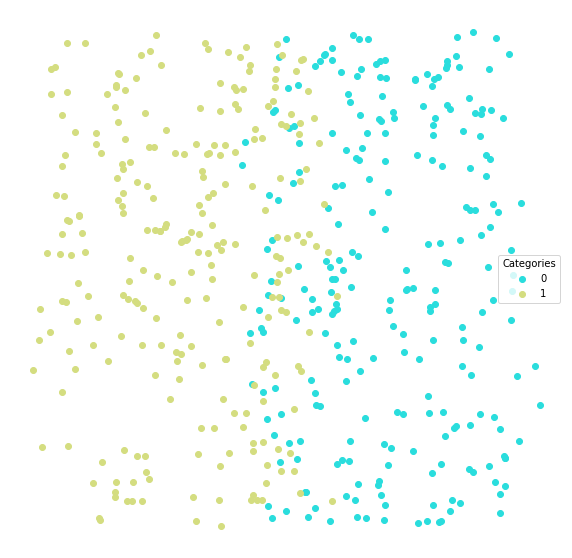

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.108  0.892128   0.902834           0.855779  0.881423
1              0.108  0.892128   0.881423           0.843779  0.902834
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.102  0.898153   0.910569           0.864196  0.885375
1              0.102  0.898153   0.885827           0.850927  0.910931
SVC(kernel='poly', probability=True)
          Error_Rate      AUC  Precision  Average_Precision   Recall
Category                                                            
0              0.114  0.88668   0.937500           0.864162  0.83004
1              0.114  0.88668   0.844203           0.824353  0.94332
KNeighborsClassifier(weights='distance')
          Error_Rate      

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.104  0.896129   0.906883           0.860932  0.885375
1              0.104  0.896129   0.885375           0.848932  0.906883
GradientBoostingClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.118  0.882295   0.904167           0.847511  0.857708
1              0.118  0.882295   0.861538           0.827314  0.906883

Count:
4



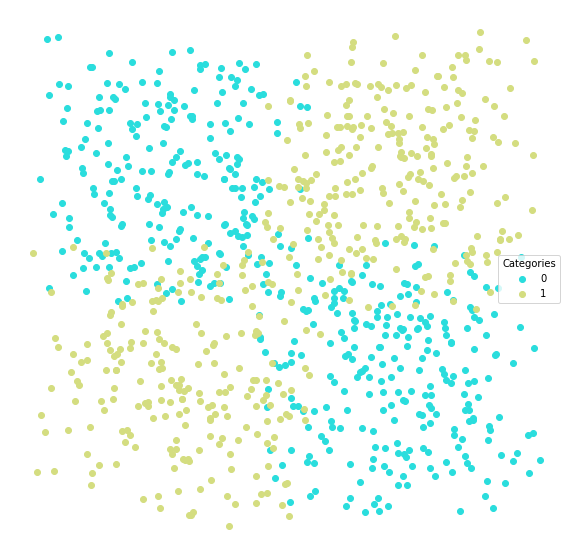

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.48  0.508117   0.450000           0.444091  0.409091
1               0.48  0.508117   0.566667           0.564048  0.607143
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.42  0.600649   0.515152           0.498072  0.772727
1               0.42  0.600649   0.705882           0.622521  0.428571
SVC(kernel='poly', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.28  0.691558   0.833333           0.618788  0.454545
1               0.28  0.691558   0.684211           0.675338  0.928571
KNeighborsClassifier(weights='distance')
          Error_Ra

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.08  0.923701   0.875000           0.855227  0.954545
1               0.08  0.923701   0.961538           0.918516  0.892857
GradientBoostingClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.08  0.923701   0.875000           0.855227  0.954545
1               0.08  0.923701   0.961538           0.918516  0.892857

Count:
5



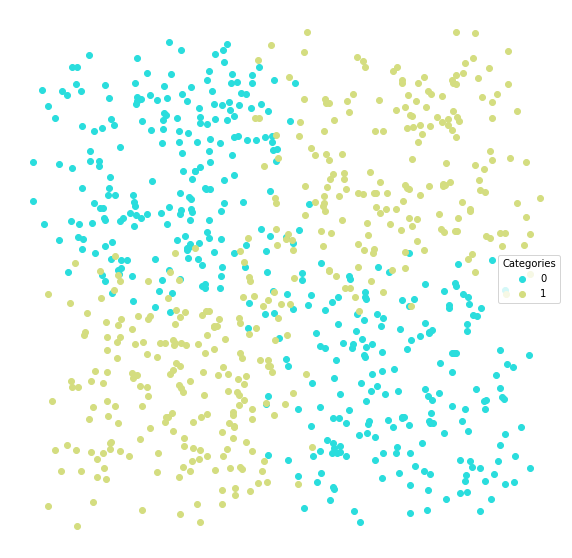

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.63  0.377358   0.373016           0.421508  0.500000
1               0.63  0.377358   0.364865           0.487937  0.254717
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.485  0.514753   0.484848           0.477582  0.510638
1              0.485  0.514753   0.544554           0.537552  0.518868
SVC(kernel='poly', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.25  0.741269   0.823529           0.680613  0.595745
1               0.25  0.741269   0.712121           0.691504  0.886792
KNeighborsClassifier(weights='distance')
          Error_Ra

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.095  0.904958   0.894737           0.854071  0.904255
1              0.095  0.904958   0.914286           0.878032  0.905660
GradientBoostingClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.105  0.896126   0.868687           0.834756  0.914894
1              0.105  0.896126   0.920792           0.872865  0.877358

Count:
6



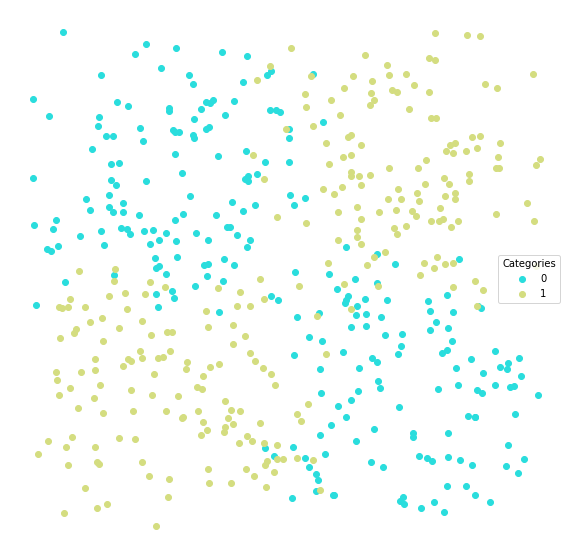

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GaussianNB()
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0              0.512  0.5      0.000              0.512     0.0
1              0.512  0.5      0.488              0.488     1.0
SVC(kernel='linear', probability=True)
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0              0.512  0.5      0.000              0.512     0.0
1              0.512  0.5      0.488              0.488     1.0
SVC(kernel='poly', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.314  0.690478   0.811321           0.662830  0.503906
1              0.314  0.690478   0.627566           0.610406  0.877049
KNeighborsClassifier(weights='distance')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Cat

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0              0.114  0.88627   0.899598           0.851149  0.875000
1              0.114  0.88627   0.872510           0.833113  0.897541
GradientBoostingClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.132  0.868308   0.883065           0.829434  0.855469
1              0.132  0.868308   0.853175           0.809773  0.881148

Count:
7



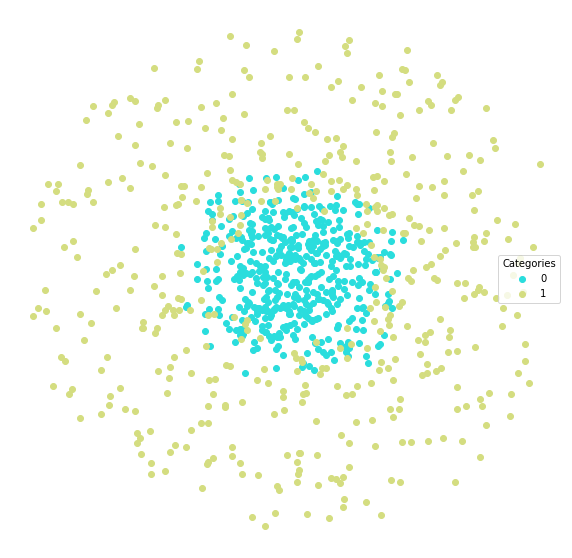

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.08  0.917898   0.931034           0.906825  0.931034
1               0.08  0.917898   0.904762           0.858594  0.904762
SVC(kernel='linear', probability=True)
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0               0.58  0.5       0.00               0.58     0.0
1               0.58  0.5       0.42               0.42     1.0
SVC(kernel='poly', probability=True)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.36  0.571429   0.617021           0.617021  1.000000
1               0.36  0.571429   1.000000           0.502857  0.142857
KNeighborsClassifier(weights='distance')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.16  0.835796   0.862069           0.823163  0.862069
1               0.16  0.835796   0.809524           0.735329  0.809524
LogisticRegression()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.68  0.380952   0.000000           0.580000  0.000000
1               0.68  0.380952   0.355556           0.370899  0.761905
DecisionTreeClassifier()
          Error_Rate       AUC  Precision  Average_Precision 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0                0.1  0.900657   0.928571           0.892512  0.896552
1                0.1  0.900657   0.863636           0.821385  0.904762
GradientBoostingClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.08  0.917898   0.931034           0.906825  0.931034
1               0.08  0.917898   0.904762           0.858594  0.904762

Count:
8



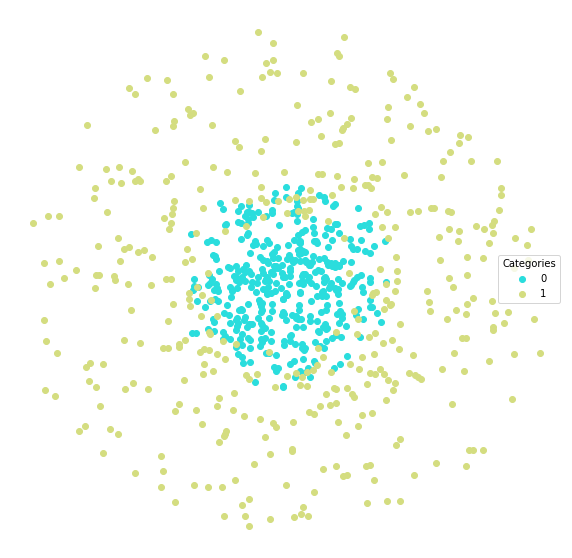

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.115  0.881268   0.862069           0.840672  0.934579
1              0.115  0.881268   0.916667           0.838961  0.827957
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.47  0.520651   0.551181           0.545586  0.654206
1               0.47  0.520651   0.493151           0.475897  0.387097
SVC(kernel='poly', probability=True)


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0              0.535  0.5      0.000              0.535     0.0
1              0.535  0.5      0.465              0.465     1.0
KNeighborsClassifier(weights='distance')
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.125  0.871219   0.853448           0.829639  0.925234
1              0.125  0.871219   0.904762           0.824375  0.817204
LogisticRegression()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.62  0.387499   0.389610           0.494237  0.280374
1               0.62  0.387499   0.373984           0.419981  0.494624
DecisionTreeClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category          

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0                0.1  0.894583   0.859504           0.850406  0.971963
1                0.1  0.894583   0.962025           0.871171  0.817204
GradientBoostingClassifier()
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0                0.1  0.89599   0.871795           0.856057  0.953271
1                0.1  0.89599   0.939759           0.863185  0.838710

Count:
9



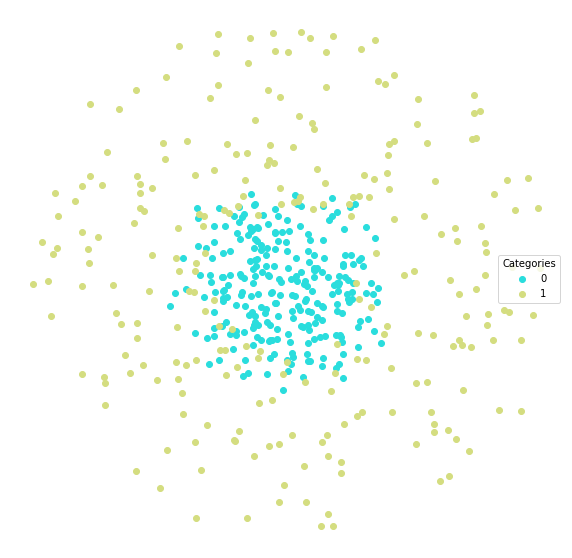

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.068  0.932373   0.913725           0.892972  0.951020
1              0.068  0.932373   0.951020           0.912972  0.913725
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.362  0.644458   0.578049           0.575174  0.967347
1              0.362  0.644458   0.911111           0.638985  0.321569
SVC(kernel='poly', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.44  0.568627   0.526882           0.526882  1.000000
1               0.44  0.568627   1.000000           0.577255  0.137255
KNeighborsClassifier(weights='distance')
          Error_Ra

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in cas

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.08  0.920848   0.883895           0.869426  0.963265
1               0.08  0.920848   0.961373           0.906501  0.878431
GradientBoostingClassifier()
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0                0.1  0.90004   0.894737           0.855089  0.902041
1                0.1  0.90004   0.905138           0.864850  0.898039

Count:
10



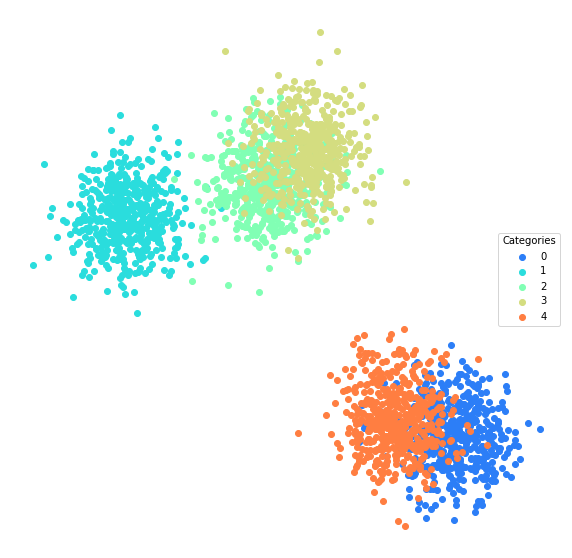

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.024  0.984848   0.896552           0.896552  1.000000
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.112  0.749740   0.625000           0.411222  0.555556
3              0.112  0.844211   0.714286           0.597451  0.769231
4              0.024  0.942308   1.000000           0.908615  0.884615
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.024  0.984848   0.896552           0.896552  1.000000
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.120  0.745067   0.588235           0.390797  0.555556
3              0.120  0.824981   0.703704           0.570245  0.730769
4              0.024  0.9

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.024  0.984848   0.896552           0.896552  1.000000
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.120  0.745067   0.588235           0.390797  0.555556
3              0.120  0.824981   0.703704           0.570245  0.730769
4              0.024  0.942308   1.000000           0.908615  0.884615
DecisionTreeClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.048  0.955517   0.833333           0.809282  0.961538
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.128  0.786604   0.545455           0.411636  0.666667
3              0.128  0.777389   0.727273           0.527552  0.615385
4              0.048  0.898796   0.954545           

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.032  0.979798   0.866667           0.866667  1.000000
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.112  0.795950   0.600000           0.448000  0.666667
3              0.112  0.815851   0.750000           0.583231  0.692308
4              0.032  0.923077   1.000000           0.878154  0.846154

Count:
11



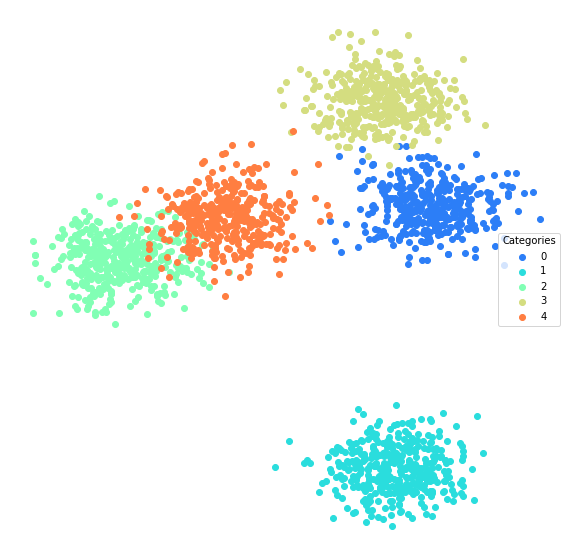

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.004  0.997409   0.982759           0.982759  1.000000
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.010  0.985344   0.967391           0.950130  0.978022
3              0.004  0.988764   1.000000           0.981528  0.977528
4              0.010  0.984465   0.982609           0.963196  0.974138
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.006  0.993023   0.982609           0.975989  0.991228
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.010  0.989616   0.957447           0.948925  0.989011
3              0.004  0.988764   1.000000           0.981528  0.977528
4              0.012  0.9

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.008  0.988637   0.982456           0.969220  0.982456
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.028  0.965797   0.896907           0.865483  0.956044
3              0.008  0.986331   0.977528           0.959561  0.977528
4              0.028  0.951688   0.963636           0.900564  0.913793
DecisionTreeClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.008  0.988637   0.982456           0.969220  0.982456
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.028  0.965797   0.896907           0.865483  0.956044
3              0.008  0.986331   0.977528           0.959561  0.977528
4              0.028  0.951688   0.963636           

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.006  0.993023   0.982609           0.975989  0.991228
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.012  0.984121   0.956989           0.939957  0.978022
3              0.004  0.988764   1.000000           0.981528  0.977528
4              0.014  0.978852   0.973913           0.948330  0.965517
GradientBoostingClassifier()


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.010  0.984251   0.982301           0.962451  0.973684
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.020  0.979231   0.917526           0.901360  0.978022
3              0.008  0.986331   0.977528           0.959561  0.977528
4              0.022  0.961611   0.972973           0.921871  0.931034

Count:
12



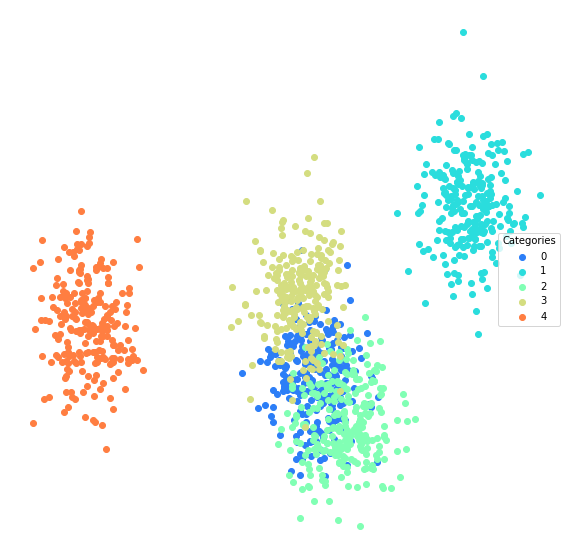

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0             0.1224  0.800706   0.689076           0.528255  0.674897
1             0.0000  1.000000   1.000000           1.000000  1.000000
2             0.0784  0.877485   0.774059           0.660531  0.807860
3             0.0456  0.925466   0.894737           0.809470  0.876984
4             0.0000  1.000000   1.000000           1.000000  1.000000
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0             0.1232  0.803331   0.683128           0.528263  0.683128
1             0.0000  1.000000   1.000000           1.000000  1.000000
2             0.0784  0.877485   0.774059           0.660531  0.807860
3             0.0464  0.920516   0.900826           0.806486  0.865079
4             0.0000  1.0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0             0.1584  0.747140   0.592593           0.430366  0.592593
1             0.0008  0.999497   0.996109           0.996109  1.000000
2             0.1000  0.835470   0.724138           0.580045  0.733624
3             0.0736  0.882718   0.822581           0.704299  0.809524
4             0.0000  1.000000   1.000000           1.000000  1.000000
DecisionTreeClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0             0.1576  0.750759   0.593496           0.434186  0.600823
1             0.0008  0.999497   0.996109           0.996109  1.000000
2             0.1000  0.837164   0.722222           0.580994  0.737991
3             0.0696  0.885223   0.839506           0.718000  0.809524
4             0.0000  1.000000   1.000000           

In [ ]:
count = 1
for dfTrain, dfTest in datasets:
  print("")
  print("Count:")
  print(count)
  print("")
  count += 1
  lucem_illud.plotter(dfTrain)
  for clf in algorithms:
    print(clf)
    clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
    print(lucem_illud.evaluateClassifier(clf, dfTest))
    #lucem_illud.plotConfusionMatrix(clf, dfTest)

#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

In [ ]:
for clf in algorithms:
  print(clf)
  clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
  print(lucem_illud.evaluateClassifier(clf, dfTest))
  #lucem_illud.plotConfusionMatrix(clf, dfTest)
  #lucem_illud.plotregions(clf, dfTrain)
  print("")
  

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.06  0.939123   0.931818           0.898285  0.931818
1               0.06  0.939123   0.946429           0.925727  0.946429

SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.06  0.939123   0.931818           0.898285  0.931818
1               0.06  0.939123   0.946429           0.925727  0.946429

SVC(kernel='poly', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.065  0.932224   0.941176           0.895615  0.909091
1              0.065  0.932224   0.930435           0.913898  0.955357

KNeighborsClassifier(weights='distance')
          Error

GaussianNB()


## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [ ]:
path = '/content/drive/MyDrive/data/senReleasesTraining.csv'
reddit = pd.read_csv(path)

In [ ]:
dfTrain

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy
136,137,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,03Aug2006Kennedy2.txt,raw/Kennedy/03Aug2006Kennedy2.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
676,677,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Apr2005Kennedy9.txt,raw/Kennedy/13Apr2005Kennedy9.txt,FOR IMMEDIATE RELEASE Mr Preside...,Kennedy
381,382,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,07Nov2007Kennedy0.txt,raw/Kennedy/07Nov2007Kennedy0.txt,FOR IMMEDIATE RELEASE WASHINGTON ...,Kennedy
295,296,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Feb2006Kennedy5.txt,raw/Kennedy/06Feb2006Kennedy5.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy
...,...,...,...,...,...,...,...
457,458,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Feb2005Kennedy11.txt,raw/Kennedy/09Feb2005Kennedy11.txt,FOR IMMEDIATE RELEASE Washington...,Kennedy
80,81,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Aug2006Kennedy9.txt,raw/Kennedy/02Aug2006Kennedy9.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
289,290,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Dec2007Kennedy8.txt,raw/Kennedy/06Dec2007Kennedy8.txt,FOR IMMEDIATE RELEASE There are s...,Kennedy
108,109,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Mar2007Kennedy11.txt,raw/Kennedy/02Mar2007Kennedy11.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy


In [10]:
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(), test_size=.2)
# dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(), test_size=.2)

Loading senate data


FileNotFoundError: ignored

In [ ]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Bayes
# clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

LogisticRegression()

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
rec.autos,0.078723,0.925076,0.792857,0.756577,0.932773
comp.sys.mac.hardware,0.055319,0.925564,0.873874,0.803199,0.889908
misc.forsale,0.085106,0.867313,0.906542,0.756228,0.763780
comp.windows.x,0.044681,0.935150,0.919643,0.849212,0.895652


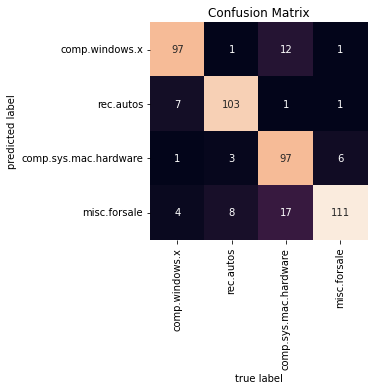

In [ ]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

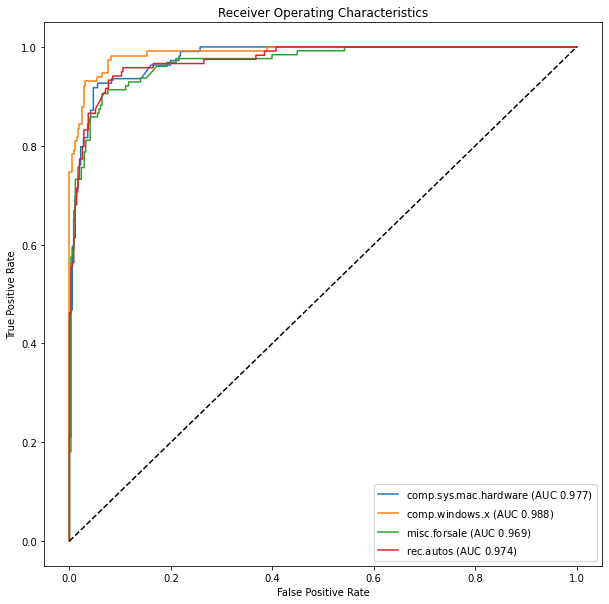

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

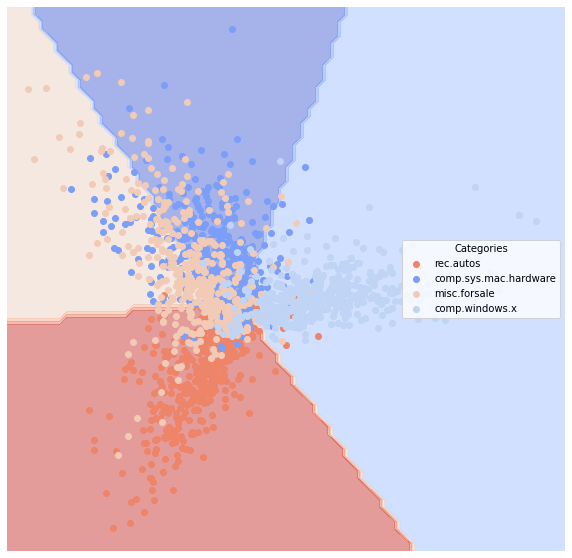

In [ ]:
lucem_illud.plotregions(clf, dfTrain)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [ ]:
# I evaluated four types of datasets and in each I set the test/ train split at 0.5 , 0.2 , and 0.5 for
# a total of 12 datasets. I trained nine algorithms on each dataset and evaluated them for error rate and 
# recall - the number of correct positive predictions made out of all positive predictions that could have 
# been made.

# Datasets 1-3:  andSplit

# All algorithms give good performance, even on the lowest split. Performance gets better as the training 
# set gets larger. In 0.2 split, best performance from SVC with a linear kernel. In 0.5 split, best performance f
# rom GaussianNB, SVC linear, logistic regression and MPC. 

# Datasets 4-6: xor

# Best performance from k-neighbors, decision trees, random forests, MPC, and boosting. Surprisingly, 
# performance is better from the lower test/train split, which is an artifact of low frequency of type II error.  
# We could use more false negatives. The largest test/train split does not give much better performance. 	

# Datasets 7-9:  target splits

# all algorithms did well except for the two SVC algorithms and the Logistic Regression model. All splits had 
# comparable performance

# Datasets 10-12: multi blobs

#  I am not sure how to evaluate the algorithms against each other. The lowest test/train split did not do well, 
# because it did not “see”” two of the blobs. 

# Datasets 13-15: real datasets

# here, using the Reddit dataset, the SVC, random forest, and decision trees did best. 

# Datasets 16-

# I was unable to load the other datasets and asked a question on GitHub on the topic.

Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors
Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors
Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



Count:
1



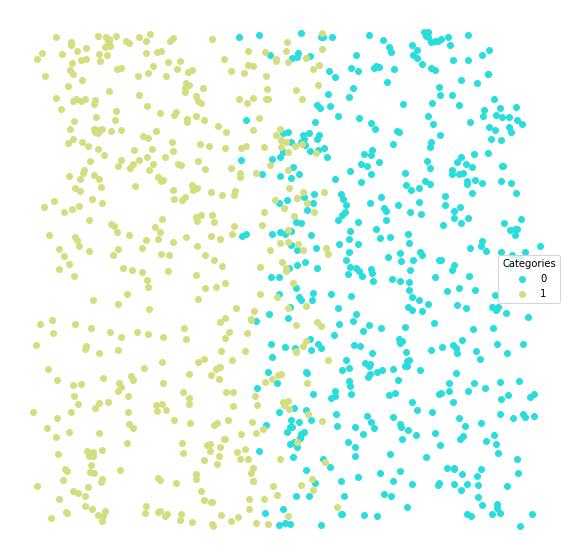

GaussianNB()
          Error_Rate   AUC  Precision  Average_Precision  Recall
Category                                                        
0               0.12  0.88       0.88             0.8344    0.88
1               0.12  0.88       0.88             0.8344    0.88
SVC(kernel='linear', probability=True)
          Error_Rate   AUC  Precision  Average_Precision  Recall
Category                                                        
0               0.12  0.88       0.88             0.8344    0.88
1               0.12  0.88       0.88             0.8344    0.88
SVC(kernel='poly', probability=True)
          Error_Rate   AUC  Precision  Average_Precision  Recall
Category                                                        
0               0.16  0.84   0.774194           0.763226    0.96
1               0.16  0.84   0.947368           0.822105    0.72
KNeighborsClassifier(weights='distance')
          Error_Rate   AUC  Precision  Average_Precision  Recall
Category                 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


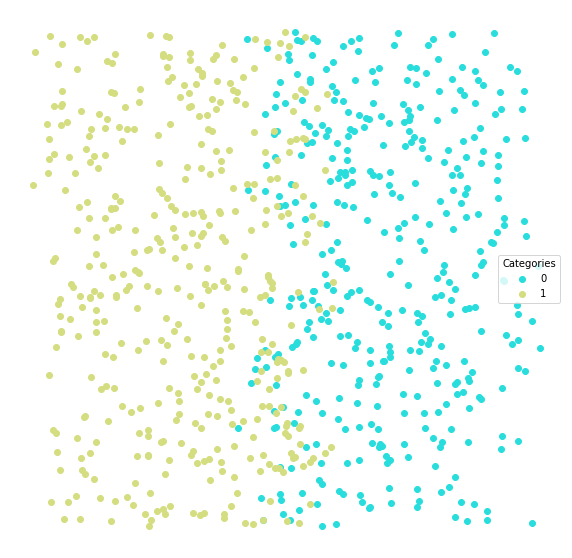

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.12  0.880682   0.907407           0.863981  0.875000
1               0.12  0.880682   0.847826           0.801482  0.886364
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0                0.1  0.900974   0.925926           0.886720  0.892857
1                0.1  0.900974   0.869565           0.830514  0.909091
SVC(kernel='poly', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.12  0.884334   0.931373           0.875004  0.848214
1               0.12  0.884334   0.826531           0.795784  0.920455
KNeighborsClassifier(weights='distance')
          Error_Ra

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


          Error_Rate    AUC  Precision  Average_Precision  Recall
Category                                                         
0              0.125  0.875   0.899083           0.856697   0.875
1              0.125  0.875   0.846154           0.795385   0.875
GradientBoostingClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.125  0.873782   0.891892           0.853369  0.883929
1              0.125  0.873782   0.853933           0.797487  0.863636

Count:
3



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


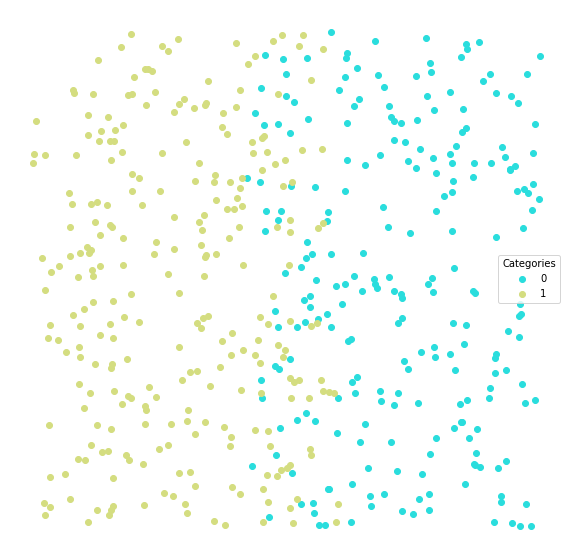

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.076  0.925013   0.945525           0.908534  0.910112
1              0.076  0.925013   0.901235           0.875083  0.939914
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.08  0.921814   0.952191           0.908336  0.895131
1               0.08  0.921814   0.887550           0.865839  0.948498
SVC(kernel='poly', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.13  0.877184   0.980952           0.878840  0.771536
1               0.13  0.877184   0.789655           0.784099  0.982833
KNeighborsClassifier(weights='distance')
          Error_Ra

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0              0.076  0.92556   0.952569           0.911810  0.902622
1              0.076  0.92556   0.894737           0.872656  0.948498
GradientBoostingClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.104  0.896337   0.911877           0.870835  0.891386
1              0.104  0.896337   0.878661           0.837926  0.901288

Count:
4



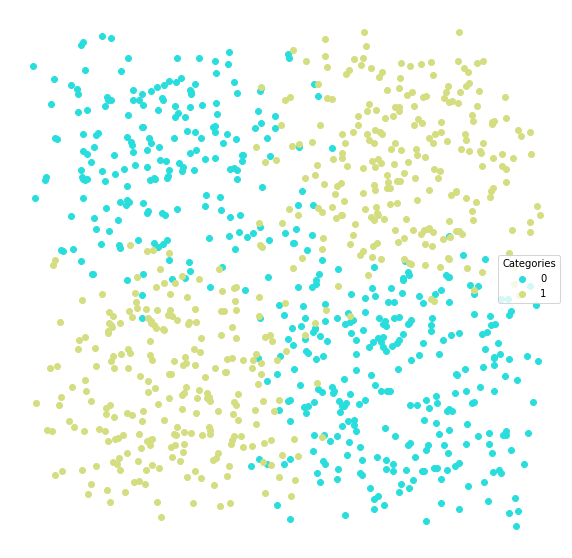

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0                0.4  0.622332   0.736842           0.655717  0.482759
1                0.4  0.622332   0.516129           0.493241  0.761905
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.34  0.700328   0.928571           0.736256  0.448276
1               0.34  0.700328   0.555556           0.549101  0.952381
SVC(kernel='poly', probability=True)
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0               0.34  0.69376   0.875000           0.722414  0.482759
1               0.34  0.69376   0.558824           0.545602  0.904762
KNeighborsClassifier(weights='distance')
          Error_Rate  

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.02  0.982759   1.000000           0.985517  0.965517
1               0.02  0.982759   0.954545           0.954545  1.000000
GradientBoostingClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.06  0.948276      1.000           0.956552  0.896552
1               0.06  0.948276      0.875           0.875000  1.000000

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.




Count:
5



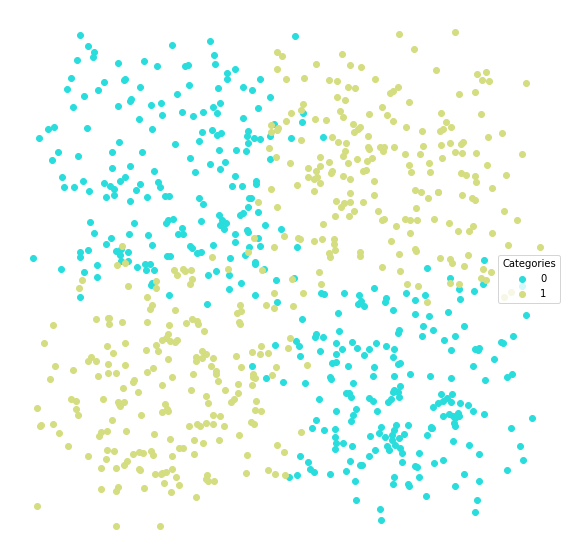

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.435  0.579509   0.661538           0.588390  0.398148
1              0.435  0.579509   0.518519           0.504525  0.760870
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.37  0.650966       0.84           0.656667  0.388889
1               0.37  0.650966       0.56           0.551304  0.913043
SVC(kernel='poly', probability=True)
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0               0.29  0.72343   0.857143           0.716190  0.555556
1               0.29  0.72343   0.630769           0.612207  0.891304
KNeighborsClassifier(weights='distance')
          Error_Rate  

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0                0.1  0.901771   0.931373           0.884263  0.879630
1                0.1  0.901771   0.867347           0.836353  0.923913
GradientBoostingClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.09  0.912641       0.95           0.900648  0.879630
1               0.09  0.912641       0.87           0.847717  0.945652

Count:
6



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


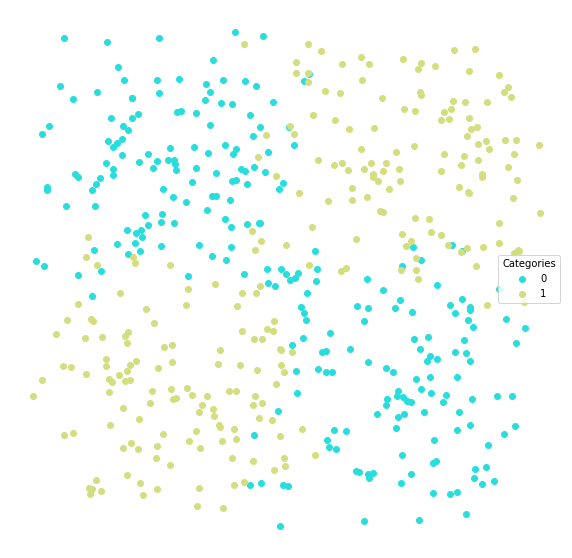

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.49  0.510528   0.506329           0.503352  0.642570
1               0.49  0.510528   0.516304           0.507414  0.378486
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.494  0.506048   0.503906           0.501060  0.518072
1              0.494  0.506048   0.508197           0.505061  0.494024
SVC(kernel='poly', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.298  0.701331   0.801205           0.659953  0.534137
1              0.298  0.701331   0.652695           0.632882  0.868526
KNeighborsClassifier(weights='distance')
          Error_Ra

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.09  0.909975   0.914634           0.874477  0.903614
1               0.09  0.909975   0.905512           0.871752  0.916335
GradientBoostingClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.108  0.891982   0.894737           0.850124  0.887550
1              0.108  0.891982   0.889328           0.849206  0.896414

Count:
7



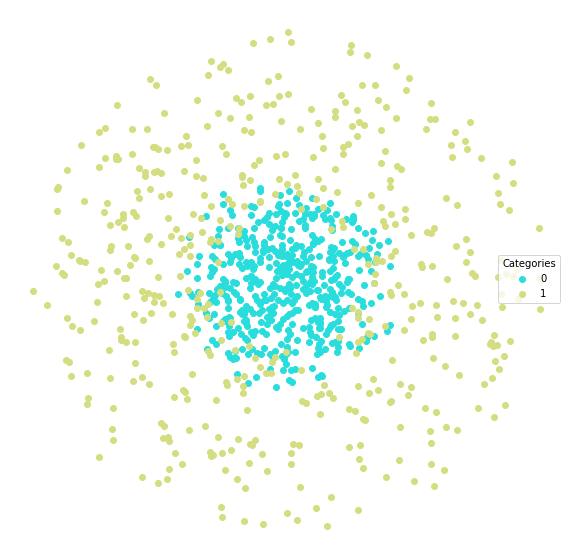

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0                0.1  0.905844       0.84           0.821818  0.954545
1                0.1  0.905844       0.96           0.902857  0.857143
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0                0.4  0.637987      0.525           0.521136  0.954545
1                0.4  0.637987      0.900           0.669286  0.321429
SVC(kernel='poly', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.46  0.589286   0.488889           0.488889  1.000000
1               0.46  0.589286   1.000000           0.638571  0.178571
KNeighborsClassifier(weights='distance')
          Error_Ra

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0                0.1  0.910714   0.814815           0.814815  1.000000
1                0.1  0.910714   1.000000           0.921429  0.821429
GradientBoostingClassifier()
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0               0.14  0.86039   0.826087           0.773439  0.863636
1               0.14  0.86039   0.888889           0.841905  0.857143

Count:
8



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


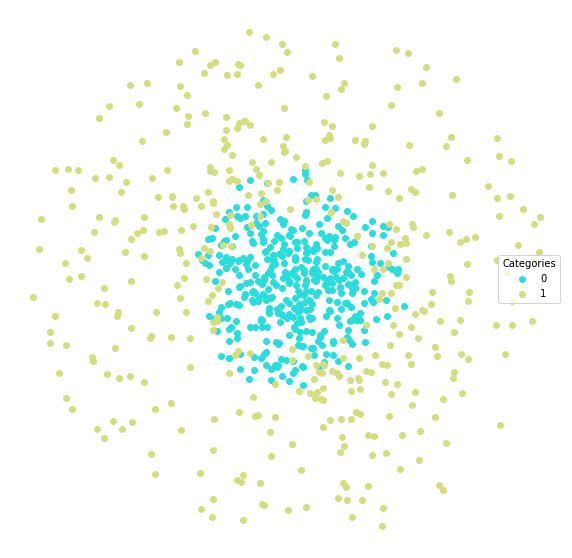

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.105  0.895032   0.902913           0.862412  0.894231
1              0.105  0.895032   0.886598           0.844244  0.895833
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.335  0.653446   0.616352           0.610793  0.942308
1              0.335  0.653446   0.853659           0.616230  0.364583
SVC(kernel='poly', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.395  0.588542   0.568306           0.568306  1.000000
1              0.395  0.588542   1.000000           0.572083  0.177083
KNeighborsClassifier(weights='distance')
          Error_Ra

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0                0.1  0.898237   0.875000           0.854519  0.942308
1                0.1  0.898237   0.931818           0.865928  0.854167
GradientBoostingClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.125  0.876202   0.907216           0.847645  0.846154
1              0.125  0.876202   0.844660           0.810473  0.906250

Count:
9



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


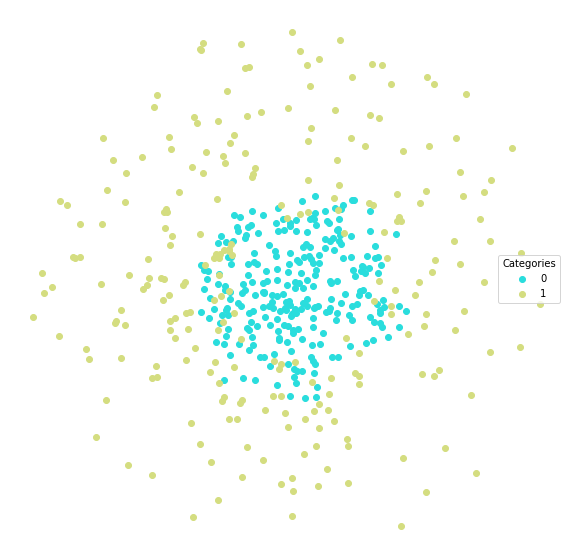

GaussianNB()
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0               0.12  0.88143   0.844106           0.815559  0.921162
1               0.12  0.88143   0.919831           0.856221  0.841699
SVC(kernel='linear', probability=True)
          Error_Rate     AUC  Precision  Average_Precision    Recall
Category                                                            
0               0.36  0.6515   0.574939           0.572239  0.970954
1               0.36  0.6515   0.924731           0.653054  0.332046
SVC(kernel='poly', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.404  0.610039   0.544018           0.544018  1.000000
1              0.404  0.610039   1.000000           0.624077  0.220077
KNeighborsClassifier(weights='distance')
          Error_Rate       AUC

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.124  0.878002   0.830258           0.807137  0.933610
1              0.124  0.878002   0.930131           0.856934  0.822394
GradientBoostingClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.13  0.871201   0.838462           0.804442  0.904564
1               0.13  0.871201   0.904167           0.841545  0.837838

Count:
10



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


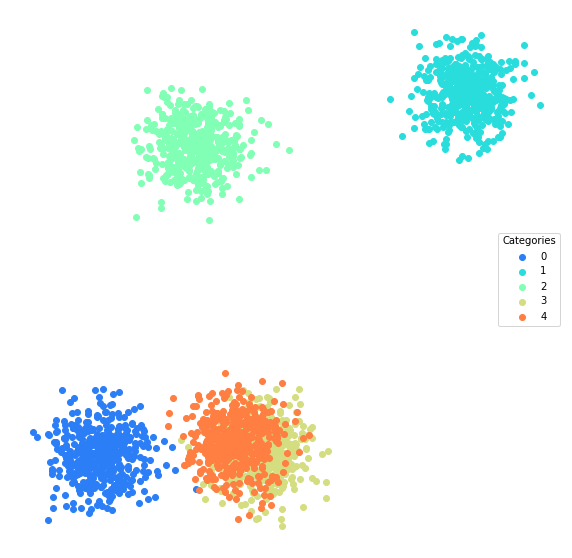

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.000  1.000000   1.000000           1.000000  1.000000
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.112  0.835396   0.692308           0.567231  0.750000
4              0.112  0.826215   0.769231           0.613451  0.714286
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.008  0.995000   0.961538           0.961538  1.000000
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.112  0.835396   0.692308           0.567231  0.750000
4              0.120  0.8

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.008  0.995000   0.961538           0.961538  1.000000
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.128  0.793729   0.666667           0.508444  0.666667
4              0.136  0.798049   0.703704           0.549513  0.678571
DecisionTreeClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.008  0.995000   0.961538           0.961538  1.000000
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.128  0.809612   0.653846           0.519141  0.708333
4              0.136  0.785346   0.720000           

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.000  1.000000   1.000000           1.000000  1.000000
1              0.000  1.000000   1.000000           1.000000  1.000000
2              0.000  1.000000   1.000000           1.000000  1.000000
3              0.096  0.845297   0.750000           0.610500  0.750000
4              0.096  0.861929   0.785714           0.665347  0.785714

Count:
11



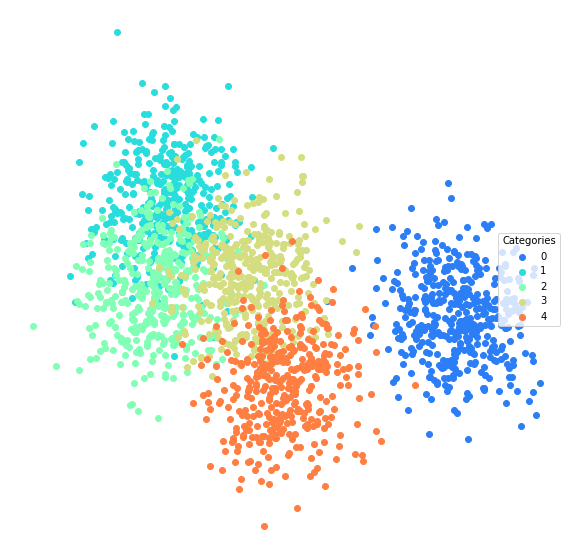

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.000  1.000000   1.000000           1.000000  1.000000
1              0.082  0.874684   0.807692           0.688154  0.800000
2              0.118  0.818842   0.705882           0.561203  0.712871
3              0.098  0.854069   0.764151           0.637488  0.771429
4              0.054  0.918604   0.878505           0.792624  0.870370
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.000  1.000000   1.000000           1.000000  1.000000
1              0.088  0.870886   0.785047           0.670037  0.800000
2              0.122  0.808941   0.700000           0.547149  0.693069
3              0.100  0.849307   0.761905           0.630499  0.761905
4              0.054  0.9

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.000  1.000000   1.000000           1.000000  1.000000
1              0.086  0.868656   0.798077           0.674861  0.790476
2              0.120  0.813891   0.702970           0.554167  0.702970
3              0.096  0.858831   0.766355           0.644487  0.780952
4              0.054  0.918604   0.878505           0.792624  0.870370
DecisionTreeClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.002  0.993827   1.000000           0.989654  0.987654
1              0.130  0.805847   0.688679           0.542796  0.695238
2              0.168  0.739448   0.584158           0.425241  0.584158
3              0.146  0.778240   0.653846           0.497443  0.647619
4              0.070  0.898337   0.834862           

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.002  0.993827   1.000000           0.989654  0.987654
1              0.092  0.857866   0.786408           0.654657  0.771429
2              0.122  0.820033   0.688679           0.553758  0.722772
3              0.108  0.837251   0.742857           0.605837  0.742857
4              0.060  0.908069   0.867925           0.771343  0.851852

Count:
12



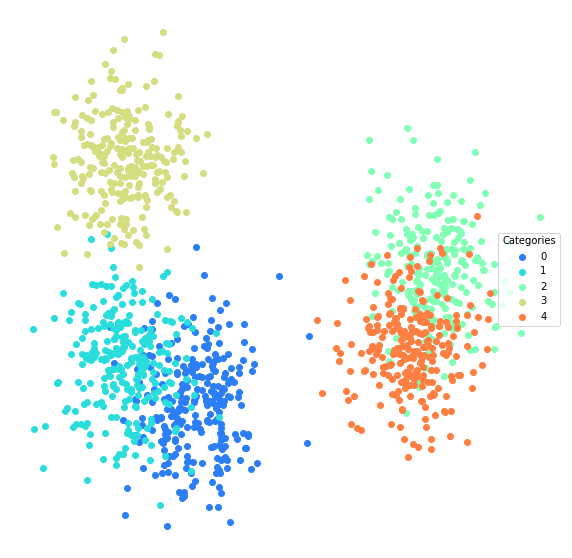

GaussianNB()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0             0.0440  0.925239   0.887446           0.800663  0.876068
1             0.0488  0.920517   0.880658           0.791701  0.869919
2             0.0776  0.880761   0.823755           0.706617  0.808271
3             0.0064  0.994530   0.973384           0.970397  0.996109
4             0.0776  0.881459   0.797619           0.685875  0.813765
SVC(kernel='linear', probability=True)
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0             0.0424  0.927868   0.891775           0.807467  0.880342
1             0.0480  0.921015   0.884298           0.794867  0.869919
2             0.0784  0.880253   0.820611           0.704076  0.808271
3             0.0056  0.996475   0.973485           0.973485  1.000000
4             0.0784  0.8

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0             0.0440  0.928528   0.880851           0.800814  0.884615
1             0.0488  0.917448   0.887029           0.791632  0.861789
2             0.0776  0.882133   0.821293           0.706914  0.812030
3             0.0064  0.994530   0.973384           0.970397  0.996109
4             0.0776  0.879933   0.800000           0.685373  0.809717
DecisionTreeClassifier()
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0             0.0792  0.852602   0.816901           0.655440  0.743590
1             0.0880  0.874632   0.757576           0.652715  0.813008
2             0.1056  0.839660   0.755725           0.616932  0.744361
3             0.0088  0.988693   0.973077           0.961132  0.984436
4             0.1056  0.836547   0.729084           

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0             0.0440  0.917016   0.904977           0.800685  0.854701
1             0.0488  0.928190   0.865613           0.792206  0.890244
2             0.0808  0.874614   0.818533           0.695565  0.796992
3             0.0080  0.992081   0.969582           0.963636  0.992218
4             0.0808  0.877939   0.787402           0.675172  0.809717
GradientBoostingClassifier()


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0             0.0528  0.905024   0.875000           0.763306  0.837607
1             0.0600  0.910476   0.837945           0.749331  0.861789
2             0.0864  0.857342   0.821138           0.674771  0.759398
3             0.0072  0.991142   0.976923           0.967919  0.988327
4             0.0864  0.879027   0.760300           0.660062  0.821862

Count:
13



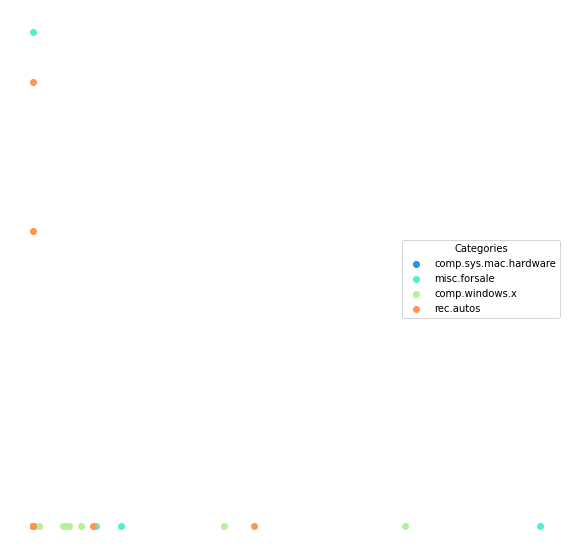

GaussianNB()
                       Error_Rate       AUC  ...  Average_Precision    Recall
Category                                     ...                             
comp.sys.mac.hardware    0.152542  0.803115  ...           0.579913  0.709677
comp.windows.x           0.067797  0.933866  ...           0.798199  0.937500
misc.forsale             0.110169  0.836119  ...           0.688540  0.718750
rec.autos                0.110169  0.832723  ...           0.574398  0.739130

[4 rows x 5 columns]
SVC(kernel='linear', probability=True)
                       Error_Rate       AUC  ...  Average_Precision    Recall
Category                                     ...                             
comp.sys.mac.hardware    0.110169  0.800704  ...           0.683953  0.612903
comp.windows.x           0.033898  0.957122  ...           0.895855  0.937500
misc.forsale             0.084746  0.902616  ...           0.754487  0.875000
rec.autos                0.110169  0.898627  ...           0.616134 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

                       Error_Rate       AUC  ...  Average_Precision    Recall
Category                                     ...                             
comp.sys.mac.hardware    0.084746  0.838710  ...           0.762165  0.677419
comp.windows.x           0.050847  0.935683  ...           0.846713  0.906250
misc.forsale             0.101695  0.832122  ...           0.714954  0.687500
rec.autos                0.186441  0.851259  ...           0.484606  0.913043

[4 rows x 5 columns]

Count:
14



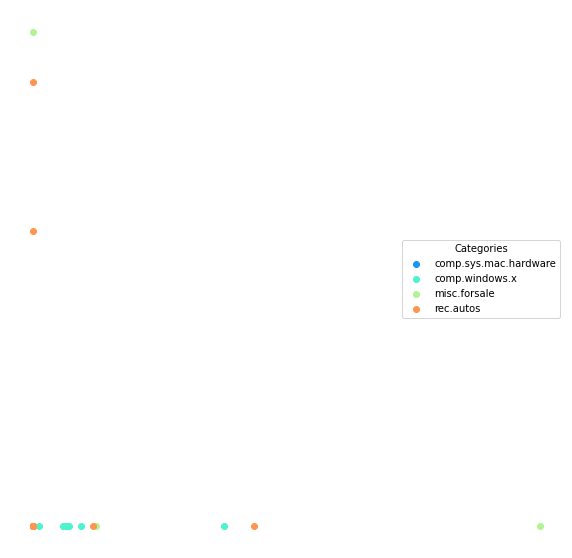

GaussianNB()
                       Error_Rate       AUC  ...  Average_Precision    Recall
Category                                     ...                             
comp.sys.mac.hardware    0.119149  0.853330  ...           0.589423  0.806122
misc.forsale             0.119149  0.824693  ...           0.684871  0.694030
comp.windows.x           0.072340  0.918895  ...           0.775075  0.900826
rec.autos                0.097872  0.866274  ...           0.693873  0.794872

[4 rows x 5 columns]
SVC(kernel='linear', probability=True)
                       Error_Rate       AUC  ...  Average_Precision    Recall
Category                                     ...                             
comp.sys.mac.hardware    0.053191  0.921302  ...           0.787849  0.877551
misc.forsale             0.070213  0.903785  ...           0.807009  0.843284
comp.windows.x           0.051064  0.930522  ...           0.837716  0.892562
rec.autos                0.068085  0.923246  ...           0.779579 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

                       Error_Rate       AUC  ...  Average_Precision    Recall
Category                                     ...                             
comp.sys.mac.hardware    0.082979  0.857390  ...           0.678901  0.755102
misc.forsale             0.119149  0.831423  ...           0.684150  0.716418
comp.windows.x           0.078723  0.909197  ...           0.757632  0.884298
rec.autos                0.119149  0.869253  ...           0.649752  0.846154

[4 rows x 5 columns]

Count:
15



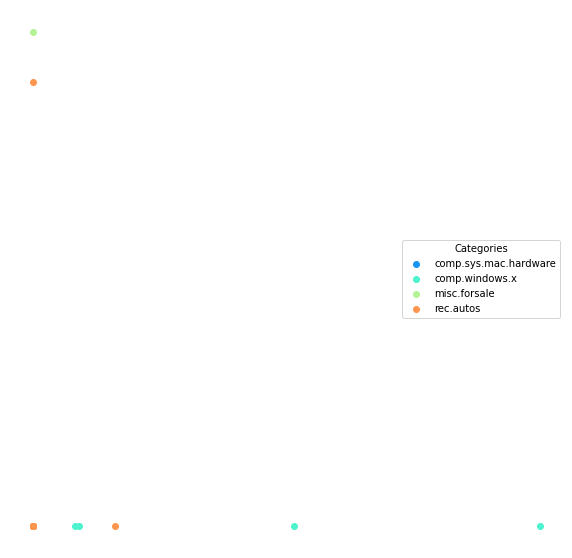

GaussianNB()
                       Error_Rate       AUC  ...  Average_Precision    Recall
Category                                     ...                             
comp.sys.mac.hardware    0.153191  0.789112  ...           0.565683  0.669967
comp.windows.x           0.080000  0.908952  ...           0.745990  0.886986
misc.forsale             0.134468  0.815247  ...           0.583995  0.718861
rec.autos                0.097021  0.867742  ...           0.702928  0.795987

[4 rows x 5 columns]
SVC(kernel='linear', probability=True)
                       Error_Rate       AUC  ...  Average_Precision    Recall
Category                                     ...                             
comp.sys.mac.hardware    0.073191  0.888235  ...           0.775011  0.808581
comp.windows.x           0.041702  0.935579  ...           0.862999  0.890411
misc.forsale             0.062979  0.918350  ...           0.785440  0.882562
rec.autos                0.079149  0.916077  ...           0.754848 

In [ ]:
# this is the code for the first part of the exercise: 

noise = 0.2

algorithms = [sklearn.naive_bayes.GaussianNB(), 
              sklearn.svm.SVC(kernel = 'linear', probability = True), 
              sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True), 
              sklearn.neighbors.KNeighborsClassifier(5, weights='distance'), 
              sklearn.linear_model.LogisticRegression(), 
              sklearn.tree.DecisionTreeClassifier(), 
              sklearn.tree.DecisionTreeClassifier(), 
              sklearn.ensemble.RandomForestClassifier(), 
              sklearn.neural_network.MLPClassifier(), 
              sklearn.ensemble.GradientBoostingClassifier()]

datasets = [
            sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.05),
            sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2),
            sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.5),
            sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.05),
            sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2),
            sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.5),
            sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.05),
            sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2),
            sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.5),
            sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.05),
            sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2),
            sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.5),
            sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.05),
            sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2),
            sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.5)

]

count = 1
for dfTrain, dfTest in datasets:
  print("")
  print("Count:")
  print(count)
  print("")
  count += 1
  lucem_illud.plotter(dfTrain)
  for clf in algorithms:
    print(clf)
    clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
    print(lucem_illud.evaluateClassifier(clf, dfTest))

In [ ]:
# I try AdaBoost, which creates "a sequence of weak learners (i.e., models that are only slightly better than 
# random guessing, such as small decision trees) on repeatedly modified versions of the data. The 
# predictions from all of them are then combined through a weighted majority vote (or sum) to produce 
# the final prediction" 

# AdaBoost performs badly on the xor dataset and well on the multiblobs dataset. 

from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

X, y = load_iris(return_X_y=True)
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.545,0.457393,0.477778,0.505661,0.409524
1,0.545,0.457393,0.436364,0.455478,0.505263


# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [17]:
path = '/content/drive/MyDrive/data/ObamaClintonReleases.csv'
ObamaClintonReleases = pandas.read_csv(path, index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame. 

In [18]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [19]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [20]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [21]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

Let's split the data into training data and testing data.

In [22]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [23]:
print(len(train_data_df))
print(len(test_data_df))

1367
342


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [24]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents. 

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean? 

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1. 

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform. 

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [25]:
TFVects.shape

(1367, 11280)

We can save this in the dataframe to make things easier

In [26]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [27]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [28]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


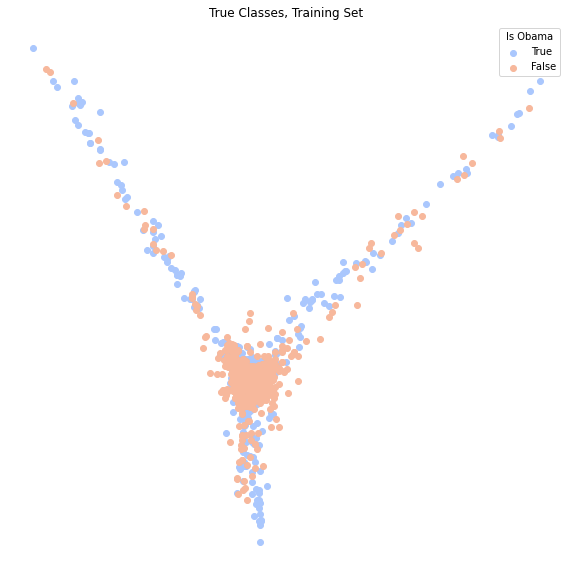

In [29]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

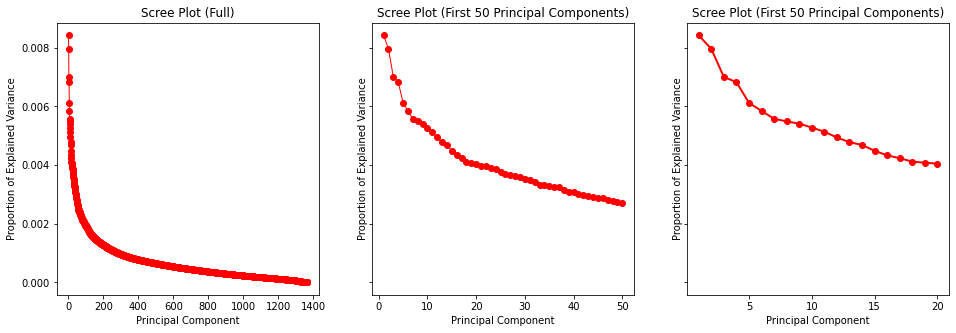

In [30]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [31]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [32]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [33]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6752011704462326

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [34]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.7017543859649122

Slightly poorer. How about using more dimensions (40)?

In [35]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7351865398683248
Testing:
0.6988304093567251


Or still more (100)?

In [36]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8361375274323336
Testing:
0.7923976608187134


Or even more (200)!

In [37]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8639356254572056
Testing:
0.8099415204678363


This is becoming ridiculous (400)!

In [38]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9158741770299926
Testing:
0.8421052631578947


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [39]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9663496708119971


Train the model using training data, and then test it on the testing data.

In [40]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8391812865497076


81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [57]:
path = '/content/drive/MyDrive/letters_and_metadata.csv'
data = pandas.read_csv(path, index_col=0)

In [58]:
data = data[(~data["letters_text"].isna())]

In [59]:
# I will be trying to predict if a letter was written after 2nd June 2015, which is the median date for this dataset. 
data['category'] = [s > "06/02/2015" for s in data['joined']]

162
41


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


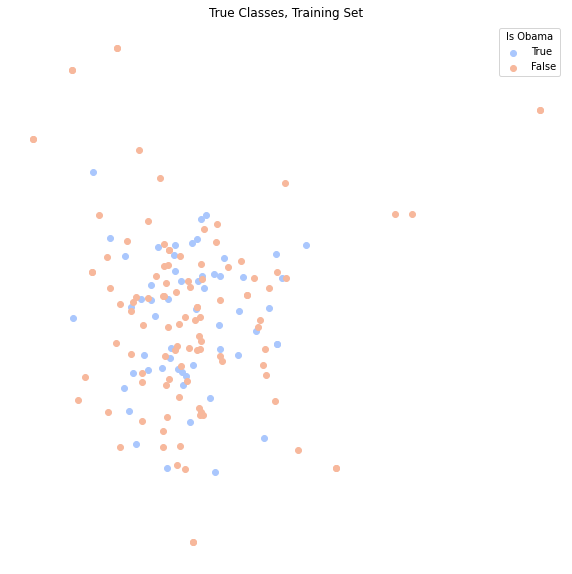

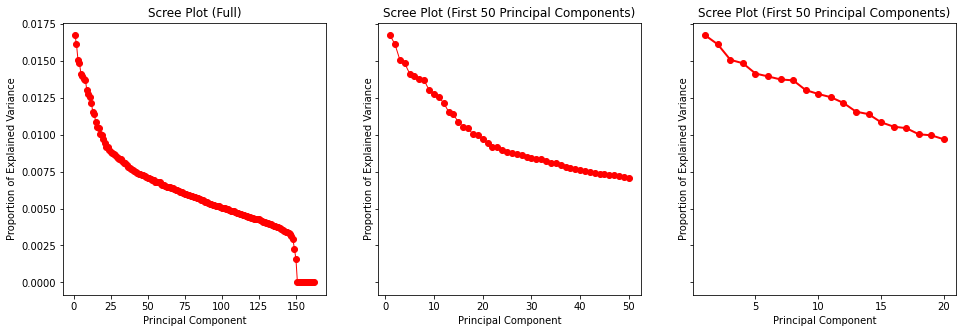

Training (40 dim):
0.6728395061728395
Testing:
0.4878048780487805
FDIDF with L1
0.7160493827160493
0.4878048780487805


In [78]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(data, test_size=holdBackFraction)


print(len(train_data_df))
print(len(test_data_df))

TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['letters_text'])

train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

train_data_df['pca'] = [r for r in reduced_data]

fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot after 2015
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot before 2015
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()


n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['letters_text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training (40 dim):")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

print("TFIDF with L1")
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))



In [80]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(lucem_illud.evaluateClassifier(logistic_l1, test_data_df))

          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
False       0.512195  0.5   0.487805           0.487805     1.0
True        0.512195  0.5   0.000000           0.512195     0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# I am able to get better than random performance with logistic regression

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

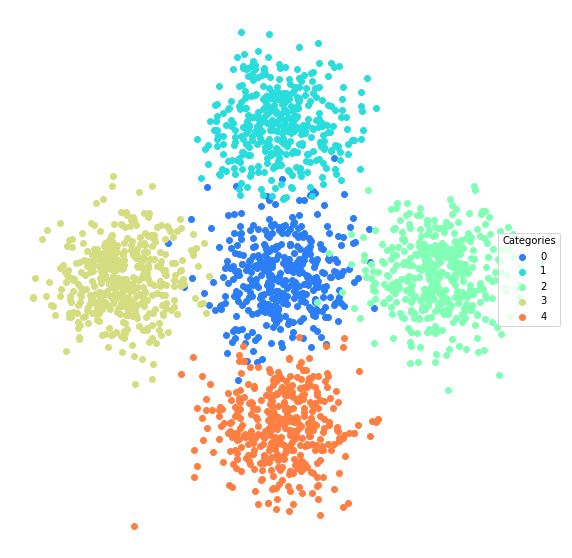

In [66]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [67]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification: 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

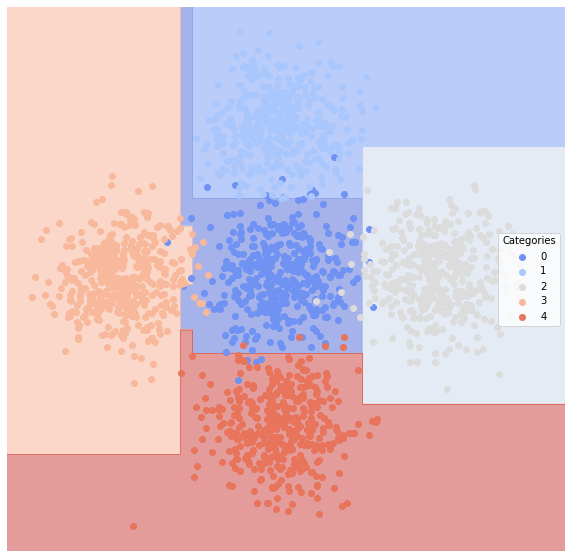

In [68]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [69]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.028,0.962321,0.908163,0.869857,0.946809
1,0.012,0.979865,0.982143,0.955682,0.964912
2,0.010,0.981071,0.977778,0.951543,0.967033
3,0.008,0.981548,0.988235,0.960158,0.965517
4,0.002,0.998705,0.991304,0.991304,1.000000


Lets look at accuracy:

In [70]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.97

What happens if we trim the tree?

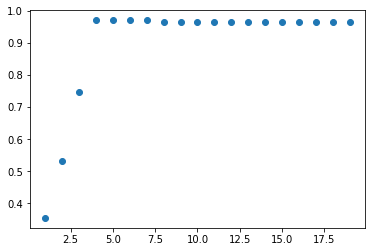

In [71]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [72]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [73]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

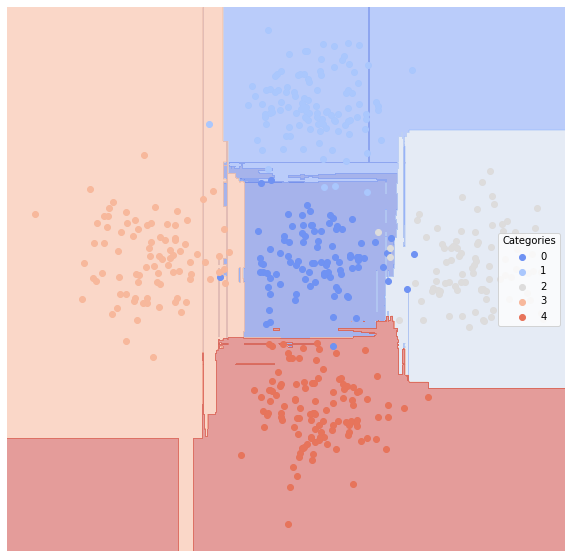

In [74]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [75]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.030,0.957001,0.907216,0.861309,0.936170
1,0.012,0.976775,0.990909,0.957448,0.956140
2,0.012,0.979849,0.967033,0.941153,0.967033
3,0.006,0.991832,0.977273,0.968040,0.988506
4,0.004,0.994319,0.991228,0.984533,0.991228


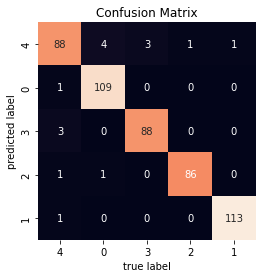

In [76]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data.

In [ ]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [ ]:
newsgroupsDF[:5]

Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Let's produce another confusion matrix:

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [run_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_glue.py) and
[run_pl_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_pl_glue.py) or
[run_tf_glue.py](https://github.com/huggingface/transformers/tree/master/examples/text-classification/run_tf_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [ ]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_squad.py) and
[run_tf_squad.py](https://github.com/huggingface/transformers/tree/master/examples/question-answering/run_tf_squad.py) scripts.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [ ]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/question-answering/run_squad.py script.
"""

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?